<a href="https://colab.research.google.com/github/DeependraParichha1004/Notebooks/blob/main/Copy_of_Image__to_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR']='/content'
# !kaggle datasets download -d adityajn105/flickr8k

In [3]:
with open('/content/drive/MyDrive/captions.txt','r') as f:
  next(f)
  cap=f.read()
  

In [4]:
mapping = {}
# process lines
for line in cap.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # print('1:',mapping)
    # store the caption
    mapping[image_id].append(caption)

In [5]:
mapping['Image3']

['A collage of photos showing .',
 'A collage of photos .',
 'A collage of images .',
 'collage of photos and images .',
 'A collage of photos .',
 'A collage of photos .',
 'A collage of photos .']

In [6]:
len(mapping.keys())

8094

In [7]:
mapping['Image3']

['A collage of photos showing .',
 'A collage of photos .',
 'A collage of images .',
 'collage of photos and images .',
 'A collage of photos .',
 'A collage of photos .',
 'A collage of photos .']

In [8]:
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import PorterStemmer
from nltk.corpus import stopwords
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [10]:
all_captions=[]
for key in mapping:
  for map in mapping[key]:
    all_captions.append(map)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
token_text=tokenizer.fit_on_texts(all_captions)

In [12]:
vocab_size = len(tokenizer.word_index) + 1

In [13]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [15]:
train_imgs=image_ids

In [16]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 20s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# extract features from image
features = {}
directory = '/content/drive/MyDrive/Flicker8k_Dataset'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8103 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join('/content', 'new_image_features(1).pkl'), 'wb'))

In [20]:
import os# load features from pickle
import pickle
with open('/content/drive/MyDrive/new_image_features(1).pkl', 'rb') as f:
    features1 = pickle.load(f)

In [17]:
len(features1.keys())

8102

In [18]:
features1['Image3'].shape

(1, 4096)

In [17]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


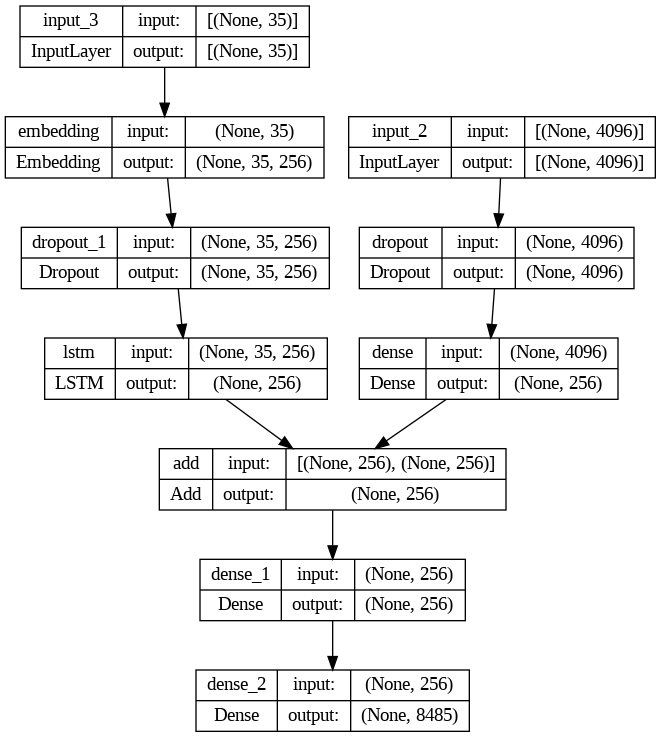

In [18]:
# Model
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model1 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model1.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model1, show_shapes=True)

In [ ]:
features1['Image1'].shape

(1, 4096)

In [21]:
# train the model
epochs = 20
batch_size = 32
steps = len(train_imgs) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_imgs, mapping, features1, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model1.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

252/252 [==============================] - 75s 296ms/step - loss: 2.0807


In [22]:
model.save('/content'+'/best_model(2).h5')

In [ ]:
recent_model=model.load('/content/best_model(1).h5')

In [23]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
word=idx_to_word(tokenizer.word_index['collage'],tokenizer)
word

'collage'

In [35]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # print(word)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/drive/MyDrive/Flicker8k_Dataset/',  image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model1, features1[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq horse is standing in field endseq
startseq horse is gazing endseq
startseq horse is standing in the grass endseq
startseq horse is gazing endseq
startseq horses are standing in field endseq
startseq horse is gazing endseq
startseq horse is gazing endseq
startseq horse are standing in field endseq
--------------------Predicted--------------------
startseq horse is walking on dirt trail endseq


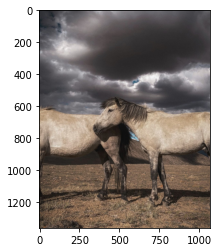

In [37]:
generate_caption("Image2.jpg")

---------------------Actual---------------------
startseq an athlete is running in field endseq
startseq player is celebrating endseq
startseq man in soccer uniform kicking soccer ball endseq
startseq man in soccer uniform endseq
startseq man is posing endseq
--------------------Predicted--------------------
startseq boy pitches in baseball game endseq


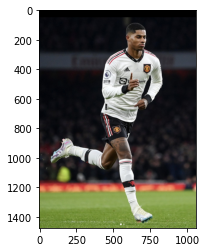

In [38]:
generate_caption("Image1.jpg")

---------------------Actual---------------------
startseq collage of photos showing endseq
startseq collage of photos endseq
startseq collage of images endseq
startseq collage of photos and images endseq
startseq collage of photos endseq
startseq collage of photos endseq
startseq collage of photos endseq
--------------------Predicted--------------------
startseq collage of images endseq


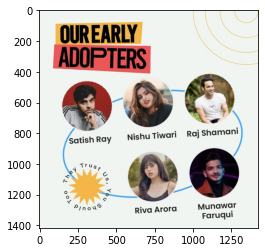

In [39]:
generate_caption("Image3.jpg")

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def demo(name):
    generate_captions

demo = gr.Interface(fn=generate_caption, inputs="image", outputs="text",description='Image To Caption Generator')